In [2]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
root = Path('../').resolve()
os.chdir(root)

Load model from checkpoint

In [5]:
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
# checkpoint_path = r"C:\Users\Vivian\Documents\CONCH\_finetune_weights\fine_tuned_model2.pth" # testing with finetuned conch model
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

Loading finetuned model

In [14]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

# Define the fine-tuned model structure
class CONCHModelForFinetuning(nn.Module):
    def __init__(self, num_classes=2, config={'hidden_size': 512}):  # Ensure num_classes matches fine-tuned task
        super().__init__()
        self.config = config
        self.model = self.make_conch()
        self.fc = nn.Linear(self.config['hidden_size'], num_classes)  # Ensure this matches training

    def make_conch(self):
        model_cfg = 'conch_ViT-B-16'
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin'  # Original checkpoint
        model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
        return model

    def forward(self, x):
        out, h = self.model.visual(x)
        return self.fc(out)

# Load the fine-tuned model structure
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CONCHModelForFinetuning().to(device)

# Load fine-tuned weights
# fine_tuned_checkpoint_path = r"C:\Users\Vivian\Documents\CONCH\_finetune_weights\fine_tuned_model2.pth"
fine_tuned_checkpoint_path = r'C:\Users\Vivian\Documents\CONCH\_finetune_weights\Fold2_F_PT_model.pth'
model.load_state_dict(torch.load(fine_tuned_checkpoint_path, map_location=device), strict=False)  # Load fine-tuned weights

model.eval()  # Set model to evaluation mode


C:\Users\Vivian\AppData\Local\Temp\ipykernel_12948\3256274974.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fine_tuned_checkpoint_pat

<All keys matched successfully>

CONCHModelForFinetuning(
  (model): CoCa(
    (text): TextTransformer(
      (token_embedding): Embedding(32007, 768)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )
      (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (visual): VisualModel(
      (trunk): Visi

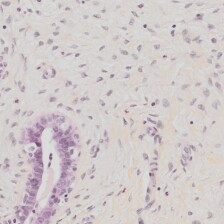

Predicted Class: B_F


In [20]:
# Define preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# # Load and preprocess the test image
# image_path = r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-010.png"  # Change to your test image path
# image = Image.open(image_path).convert("RGB")
# image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# attempting to load in numpy arrays for patches
import numpy as np
import torch
from PIL import Image

# Load the NumPy array representing your patch
patch_array = np.load(r"C:\Users\Vivian\Documents\CONCH\patches\40x\PT\PT 43 B2\patch_81_x6720_y1568.npy")  # e.g., "C:\...\patch_0_x224_y448.npy"

# Convert NumPy array to PIL Image for consistent preprocessing
patch_image = Image.fromarray(patch_array)
display(patch_image)
# # Apply your preprocessing steps (assuming you defined 'preprocess' previously)
image_tensor = preprocess(patch_image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Get predicted class
predicted_class = torch.argmax(output, dim=1).item()

# Define class labels (ensure it matches your fine-tuning labels)
# label_map = {0:'B_A', 1:'B_F', 2:'B_PT', 3:'B_TA', 4:'M_DC', 5:'M_LC', 6:'M_MC', 7:'M_PC'} # Adjust based on fine-tuning setup
label_map = {0:'B_F', 1:'B_PT'}

# Print result
print(f"Predicted Class: {label_map[predicted_class]}")


In [19]:
def evaluate_slide(npy_dir, true_label):
    """
    Evaluate all NumPy image arrays in a directory and compute classification accuracy.
    
    :param npy_dir: Path to directory containing .npy image arrays.
    :param true_label: Integer representing the correct class for this slide.
    """
    correct = 0
    total = 0
    all_predictions = []

    # Loop through all NumPy image files in the directory
    for filename in os.listdir(npy_dir):
        if filename.endswith('.npy'):
            image_path = os.path.join(npy_dir, filename)
            image_array = np.load(image_path)  # Load the NumPy array

            # Convert NumPy array to tensor and preprocess
            image_tensor = transform(image_array).unsqueeze(0).to(device)  # Add batch dimension
            
            with torch.no_grad():
                output = model(image_tensor)  # Run inference
                predicted_class = torch.argmax(output, dim=1).item()
                all_predictions.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class == true_label:
                correct += 1
            total += 1

    # Compute accuracy
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"Slide Accuracy: {accuracy:.2f}% ({correct}/{total} correctly classified)")
    return accuracy, all_predictions


In [22]:
def evaluate_slide(image_dir, true_label):
    """
    Evaluate all PNG images in a directory and compute classification accuracy.

    :param image_dir: Path to directory containing PNG images.
    :param true_label: Integer representing the correct class for this slide.
    """
    correct = 0
    total = 0
    all_predictions = []

    # Loop through all PNG image files in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):  # Only process PNG images
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert("RGB")  # Ensure RGB mode

            # Preprocess image
            image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
            
            with torch.no_grad():
                output = model(image_tensor)  # Run inference
                predicted_class = torch.argmax(output, dim=1).item()
                all_predictions.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class == true_label:
                correct += 1
            total += 1

    # Compute accuracy
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"Slide Accuracy: {accuracy:.2f}% ({correct}/{total} correctly classified)")
    return accuracy, all_predictions


In [ ]:
# Define test directory containing NumPy image arrays for one slide
# slide_dir = r"C:\Users\Vivian\Documents\CONCH\patches\40x\PT\PT 43 B2" # numpy
slide_dir = r"C:\Users\Vivian\Documents\CONCH\patches_png\PT74_B2_level9" # png

# Define the true class label for this slide (use the same label mapping as training)
label_map = {"B_F": 0, "B_PT": 1}  # Adjust if needed
true_label = label_map["B_PT"]  # Set correct label for this slide

# Run evaluation
slide_accuracy, predictions = evaluate_slide(slide_dir, true_label)

# Print predictions for debugging
print(f"Predictions for all images in {slide_dir}: {predictions}")


Slide Accuracy: 2.97% (50/1682 correctly classified)
Predictions for all images in C:\Users\Vivian\Documents\CONCH\patches_png\PT74_B2_level9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

: 

Open an image and preprocess it

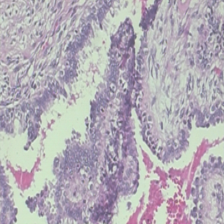

In [5]:
# image = Image.open('C:\\Users\\Vivian\\Documents\\CONCH\\docs\\roi1.jpg')
# image = Image.open(r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png") # sample benign image from breakhis
# image = Image.open(r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-010.png") # sample malignant image from breakhis
# image = Image.open(r"C:\Users\Vivian\Documents\FA 57B-image.tif")
image = Image.open(r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign\SOB\phyllodes_tumor\SOB_B_PT_14-21998AB\100X\SOB_B_PT-14-21998AB-100-019.png") # sample PT patch from our dataset
image_tensor = preprocess(image).unsqueeze(0).to(device)
image.resize((224, 224))

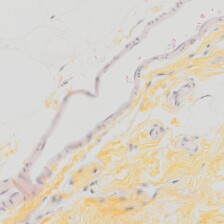

In [ ]:
# attempting to load in numpy arrays for patches
import numpy as np
import torch
from PIL import Image

# Load the NumPy array representing your patch
patch_array = np.load(r"C:\Users\Vivian\Documents\FA47_B1_level9_numpy\patch_0_x1344_y448.npy")  # e.g., "C:\...\patch_0_x224_y448.npy"

# Convert NumPy array to PIL Image for consistent preprocessing
patch_image = Image.fromarray(patch_array)

# # Apply your preprocessing steps (assuming you defined 'preprocess' previously)
image_tensor = preprocess(patch_image).unsqueeze(0).to(device)

# Resize the image if required
patch_image = patch_image.resize((224, 224))
display(patch_image)


Load tokenizer and specify some prompts. Simplicity we just use one prompt per class (lung adenocarcinoma vs. lung squamous cell carcinoma) here instead ensembling multiple prompts / prompt templates.

In [5]:
tokenizer = get_tokenizer()
classes = ['invasive ductal carcinoma', 
           'invasive lobular carcinoma']
prompts = ['an H&E image of invasive ductal carcinoma', 
           'an H&E image of invasive lobular carcinoma']

In [6]:
tokenizer = get_tokenizer()
classes = ['benign', 
           'malignant']
prompts = ['an H&E image of benign breast tumor', 
           'an H&E image of malignant breast tumor']

In [11]:
tokenizer = get_tokenizer()
classes = ['fibroadenoma', 
           'phyllodes tumor']
prompts = ['an H&E image of a fibroadenoma', 
           'an H&E image of a phyllodes tumor']

In [8]:
tokenizer = get_tokenizer()
classes = [ 'phyllodes tumor', 'fibroadenoma',]
prompts = ['an H&E image of a phyllodes tumor', 'an H&E image of a fibroadenoma']

In [12]:
tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([2, 128])

In [13]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T * model.logit_scale.exp()).softmax(dim=-1).cpu().numpy()

print("Predicted class:", classes[sim_scores.argmax()])
print("Normalized similarity scores:", [f"{cls}: {score:.3f}" for cls, score in zip(classes, sim_scores[0])])

Predicted class: fibroadenoma
Normalized similarity scores: ['fibroadenoma: 0.999', 'phyllodes tumor: 0.001']
